# Juggling RL project

## Install dependencies

In [1]:
#!pip install gymnasium
#!pip install keras-rl
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces

## Import model

""

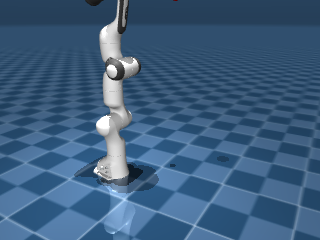

In [6]:
# Make model and data
model = mujoco.MjModel.from_xml_path("./robot/scene.xml")
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [7]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.ctrl[2]=-1.9
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

## Create the gym environment

We created our environment in envs/Juggling_Env.py.

In [1]:
import gymnasium as gym
import custom_gym

env = gym.make('Juggler',render_mode="rgb_array")

/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:190: UserWarning: WARN: Future gymnasium versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:203: UserWarning: WARN: Future gymnasium versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:211: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'NoneType'>`
  logger.warn(
/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/

""

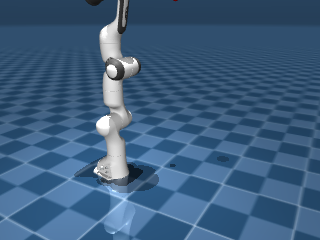

/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:293: UserWarning: WARN: RGB-array rendering should return a numpy array, got <class 'NoneType'>
  logger.warn(


In [2]:
env.reset()
env.step([0,0,-1.9])
env.render()

""

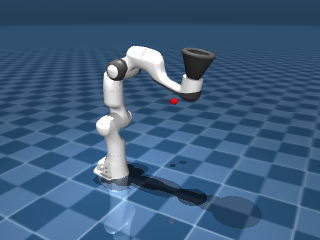

In [35]:
env.step([0,0,-1.9])
env.render()

## Create a deep learning model

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

## Keras RL agent

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)